In [30]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
plt.style.use('ggplot')
import os
os.chdir(r"D:\7-学习资料\a-study\machinlearning\万门大学课件\课件（四）\0818\下午\大豆价格预测\ARIMA")

data = pd.read_csv('soybean_price_guangdong.csv', parse_dates=['date'], index_col=['date'])
data.index = pd.to_datetime(data.index)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1351 entries, 2010-01-04 to 2014-06-06
Data columns (total 1 columns):
price    1351 non-null int64
dtypes: int64(1)
memory usage: 21.1 KB


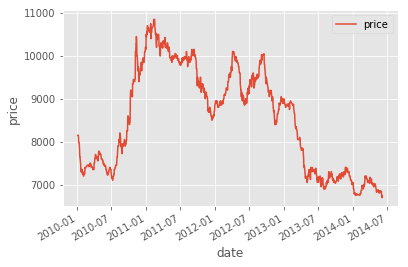

In [31]:
data.head()
data.plot()
plt.ylabel('price')
data.info()

In [32]:
ts = data['price']
ts.head()
ts.head().index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08'],
              dtype='datetime64[ns]', name='date', freq=None)

In [33]:
# ts['2014']
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=60).mean()
    rolstd = timeseries.rolling(window=60).std()
    plt.figure(figsize=(10,5))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print('Results of Dickey-Fuller Test:')
    df_test = adfuller(timeseries, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value(%s)'%key] = value
    print(df_output)
# p-value值低于0.05，表示可以拒绝原假设，即非平稳

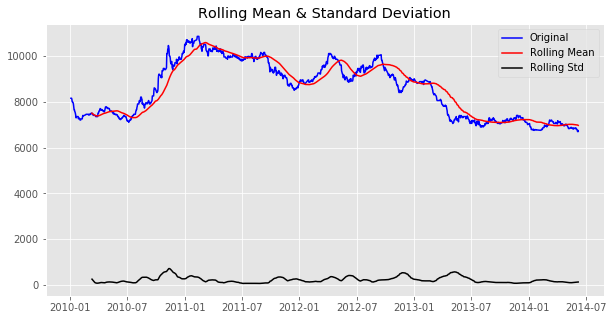

Results of Dickey-Fuller Test:
Test Statistic                   -0.930854
p-value                           0.777642
Lags Used                        11.000000
Number of Observations Used    1339.000000
Critical Value(1%)               -3.435243
Critical Value(5%)               -2.863701
Critical Value(10%)              -2.567920
dtype: float64


In [34]:
test_stationarity(ts)

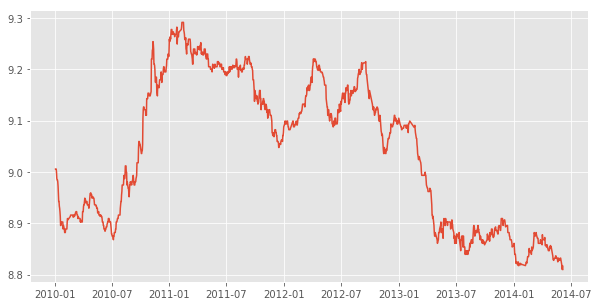

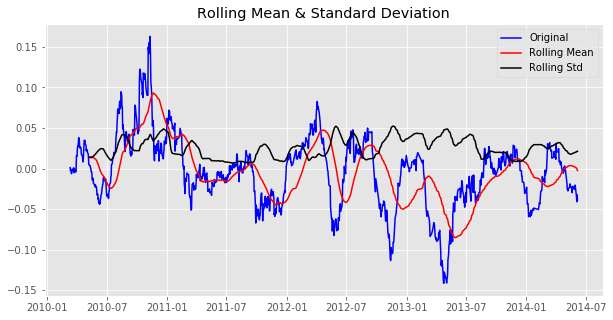

Results of Dickey-Fuller Test:
Test Statistic                   -4.092031
p-value                           0.000998
Lags Used                        12.000000
Number of Observations Used    1279.000000
Critical Value(1%)               -3.435473
Critical Value(5%)               -2.863802
Critical Value(10%)              -2.567975
dtype: float64


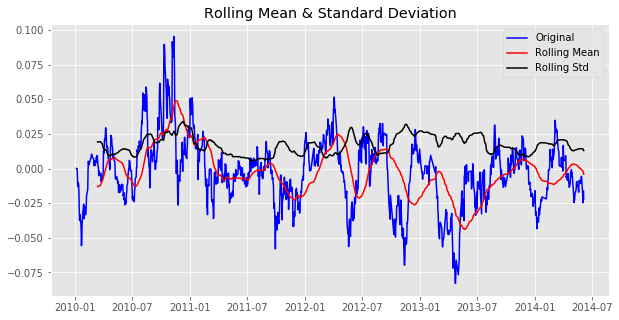

Results of Dickey-Fuller Test:
Test Statistic                   -4.693384
p-value                           0.000087
Lags Used                         8.000000
Number of Observations Used    1342.000000
Critical Value(1%)               -3.435232
Critical Value(5%)               -2.863696
Critical Value(10%)              -2.567918
dtype: float64


In [35]:
#平稳性处理
ts_log = np.log(ts)
plt.figure(figsize=(10,5))
plt.plot(ts_log)
# 通过滑动平均评估趋势
moving_avg = ts_log.rolling(window=60).mean()
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)
# 加权移动平均
expwighted_avg = ts_log.ewm(span=30).mean()
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

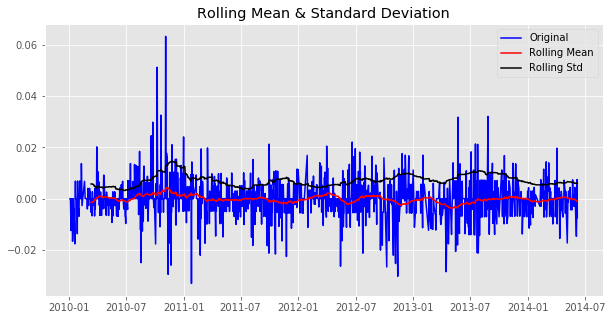

Results of Dickey-Fuller Test:
Test Statistic                -9.508675e+00
p-value                        3.294178e-16
Lags Used                      1.000000e+01
Number of Observations Used    1.339000e+03
Critical Value(1%)            -3.435243e+00
Critical Value(5%)            -2.863701e+00
Critical Value(10%)           -2.567920e+00
dtype: float64


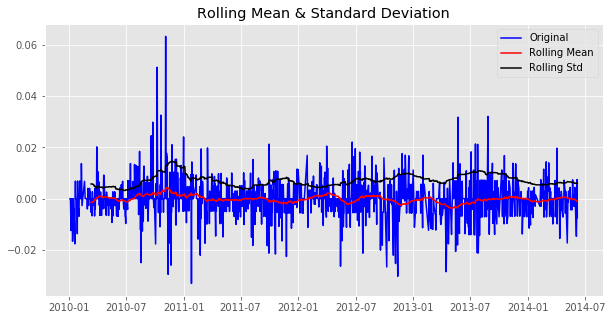

Results of Dickey-Fuller Test:
Test Statistic                -9.508675e+00
p-value                        3.294178e-16
Lags Used                      1.000000e+01
Number of Observations Used    1.339000e+03
Critical Value(1%)            -3.435243e+00
Critical Value(5%)            -2.863701e+00
Critical Value(10%)           -2.567920e+00
dtype: float64


In [36]:
# 一阶差分
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)
#另外一种方法做一阶差分
diff_1 = ts_log.diff(1)
diff_1.dropna(inplace=True)
test_stationarity(diff_1)

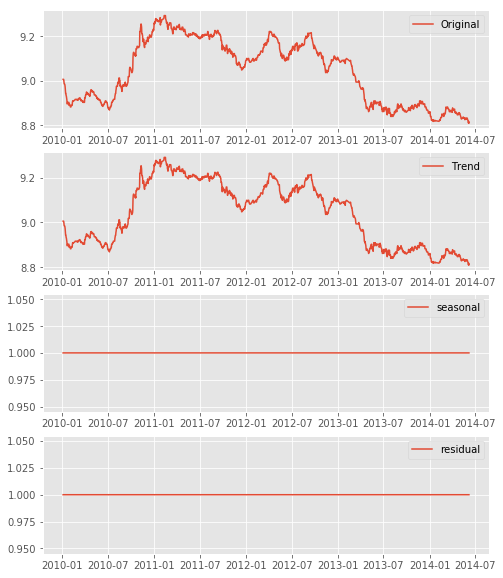

In [37]:
# 分解----将时间序列数据分解成不同的成分，例如长期趋势、季节趋势和随机成分
decomposition = seasonal_decompose(ts_log, freq=1, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(8,10))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residual')
plt.legend(loc='best')

Text(0.5, 1.0, 'Partial Autocorrelation Function')

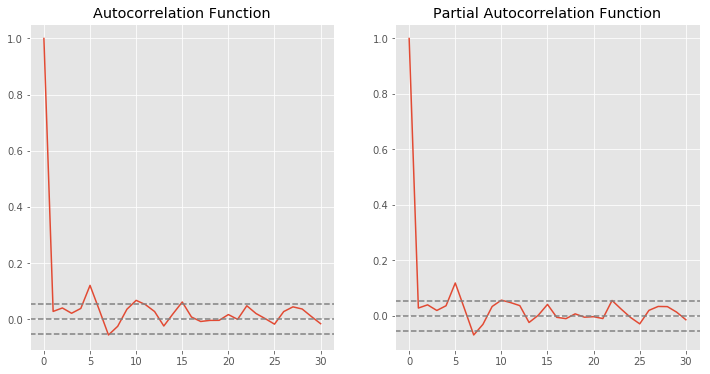

In [40]:
'''采用ACF和PACF来确定参数p（AR）和q（MR）'''
lag_acf = acf(ts_log_diff, nlags=30)
lag_pacf = pacf(ts_log_diff, nlags=30, method='ols')
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#plot_pacf
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

C:\Users\qianli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\qianli\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0728')

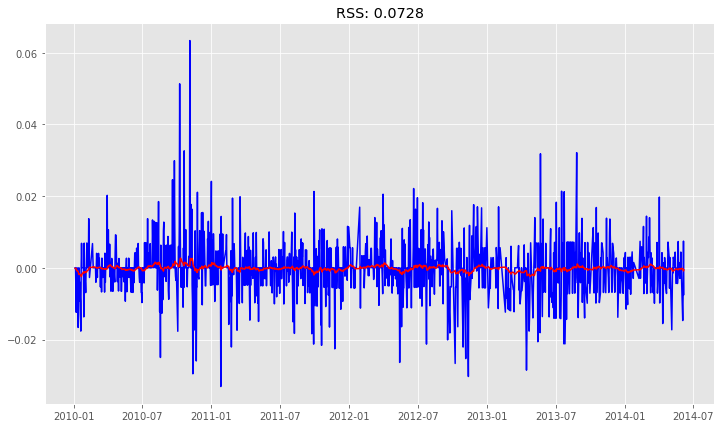

In [43]:
'''模型构造--AR模型'''
model = ARIMA(ts_log, order=(2,1,2))
results_AR = model.fit()
plt.figure(figsize=(12, 7))
plt.plot(ts_log_diff, color='blue')
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

In [46]:
'''把所计算的结果转变为原来的尺度'''
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

predictions_ARIMA_log=pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log=predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\qianli\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys


date
2010-01-04    9.005773
2010-01-05    9.005603
2010-01-06    9.005440
2010-01-07    9.005283
2010-01-08    9.004899
dtype: float64

Text(0.5, 1.0, 'RMSE: 1249.0703')

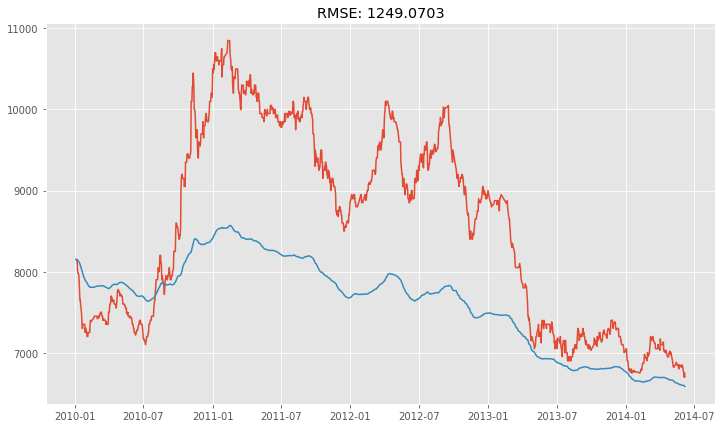

In [47]:
predictions_ARIMA=np.exp(predictions_ARIMA_log)
plt.figure(figsize=(12,7))
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))